In [238]:
import pandas as pd
import os
import numpy as np
import mplhep as hep
from matplotlib import pyplot as plt
plt.style.use(hep.style.ROOT)

In [239]:
def chi2(pre,obs,sig): 
    out = (obs - pre)**2/sig**2
    out = out.sum()
    return out

### check the train sample and DNN output

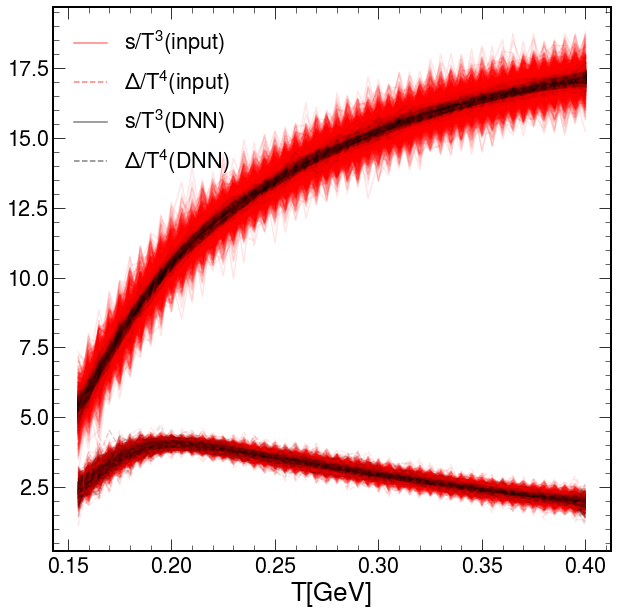

In [240]:
for j in range(2):
    for i in range(500):
        df1 = np.load("./data/sample_%s.npz"%(500 * j + i))
        df2 = np.load("./QCD_ex%s/run%s/data/EoS_data_MC.npz"%(j+1, 500 * j + i))
        s_over_T3_NN= df2["s_pred"] 
        D_over_T4_NN = df2["Delta"] 

        s_over_T3= df1["s_over_T3"] 
        D_over_T4 = df1["D_over_T4"] 
        P_over_T4 = df1["P_over_T4"] 
        E_over_T4 = df1["E_over_T4"] 
        if i == 0 and j == 0:
            plt.plot(df1["T"], s_over_T3, "r",alpha= 0.5,label="$s/T^3(input)$")
            plt.plot(df1["T"], D_over_T4, "r--",alpha=0.5, label="$\Delta/T^4(input)$")
            plt.plot(df2["T"], s_over_T3_NN/df2["T"]**3, "k",alpha= 0.5,label="$s/T^3$(DNN)")
            plt.plot(df2["T"], D_over_T4_NN/df2["T"]**4, "k--",alpha=0.5, label="$\Delta/T^4$(DNN)")
        else:
            plt.plot(df1["T"], s_over_T3, "r",alpha= 0.1)
            plt.plot(df1["T"], D_over_T4, "r--",alpha=0.1)       
            plt.plot(df2["T"], s_over_T3_NN/df2["T"]**3, "k",alpha= 0.1)
            plt.plot(df2["T"], D_over_T4_NN/df2["T"]**4, "k--",alpha=0.1) 
plt.xlabel("T[GeV]", loc="center")
plt.legend(loc="upper left")

### calculate the $\omega$


1、loss function: $\chi^2_s$ + $\chi^2_\Delta$ +mass

2、In this case, we need to calculate $\omega_{s,i}$ and $\omega_{\Delta,i}$

$$
\chi_s^2 = \frac{(s_{pred} - s_{input})^2}{\sigma_s^2}
$$
$$
\chi_\Delta^2 = \frac{(\Delta_{pred} - \Delta_{input})^2}{\sigma_\Delta^2}
$$

### normalization：
$$\omega_{i} =\frac{ \exp (-\chi_s^2- \chi_\Delta^2) }{\sum_{n=1}^{1000}\exp (-\chi_s^2- \chi_\Delta^2)}$$
$$\omega_{i} =\frac{ \exp (-\chi_s^2- \chi_\Delta^2 - Loss_{MC}) }{\sum_{n=1}^{1000} \exp (-\chi_s^2- \chi_\Delta^2 - Loss_{MC})}$$



### plot the distribution of $\omega$

In [241]:
chi2_s_list = [] # \chi_2 of s
chi2_d_list = [] # \chi_2 of delta
chi2_MC_list = [] # mass constraint mae
sigma_s_list = []  # s sample err [0, sigma_s/T^3], 50 points
sigma_D_list = [] # delta sample err [0, sigma_delta_T^4] 50 points
sigma_1_list = [] # s err from lattice
sigma_2_list = [] # delta err from lattice

for j in range(2):
    for i in range(500):
        LQCD = pd.read_csv("./data/hotqcd_1407.6387_err.csv")
        sigma_1 = LQCD["ds"] * LQCD["T"] ** 3
        sigma_2 = LQCD["dTraceA"] * LQCD["T"] ** 4
        NN = np.load("../withMC/QCD_ex%s/run%s/data/EoS_data_MC.npz"%(j+1, 500 * j + i))
        sam = np.load("./data/sample_%s.npz"%(500 * j + i))
        s_pred = NN["s_pred"] 
        Delta = NN["Delta"]
        mc = NN["loss_mc"]

        s_true = sam["s_over_T3"] * sam["T"] ** 3        
        D_true = sam["D_over_T4"] * sam["T"] ** 4
        chi2_s = chi2(s_true.reshape(-1,1), s_pred.reshape(-1,1), sigma_1.values.reshape(-1,1))
        chi2_d = chi2(D_true.reshape(-1,1), Delta.reshape(-1,1), sigma_2.values.reshape(-1,1))
        
        chi2_s_list.append(chi2_s)
        chi2_d_list.append(chi2_d)
        chi2_MC_list.append(mc)
        sigma_s = s_true - LQCD["s/T^3"]* LQCD["T"] ** 3
        sigma_D= D_true - LQCD["TraceA"]* LQCD["T"] ** 4
        sigma_s_list.append(sigma_s)
        sigma_D_list.append(sigma_D)
        sigma_1_list.append(sigma_1)
        sigma_2_list.append(sigma_2)
        

In [243]:
sigma_s_arr = np.array(sigma_s_list)
sigma_D_arr = np.array(sigma_D_list)
MC_arr = np.array(chi2_MC_list)

sigma_1_arr = np.array(sigma_1_list)
sigma_2_arr = np.array(sigma_2_list)

In [244]:
chi2si = np.array(chi2_s_list).reshape(-1,1)
chi2di = np.array(chi2_d_list).reshape(-1,1)
chi2MC = np.array(MC_arr).reshape(-1,1)

In [245]:
p1_sample_data = sigma_s_arr ** 2/(2 * sigma_1**2)
p2_sample_data = sigma_D_arr ** 2/(2 * sigma_2 ** 2)

In [246]:
omega_i = np.exp(- chi2si - chi2di)
p_data_sample = np.exp( - (p1_sample_data.sum(1)).reshape(-1,1)- (p2_sample_data.sum(1)).reshape(-1,1))
omega_i = np.exp(- chi2si - chi2di - (p1_sample_data.sum(1)).reshape(-1,1) - (p2_sample_data.sum(1)).reshape(-1,1))
omegai = omega_i/omega_i.sum()

In [247]:
 omegai.max()

0.7676188322901785

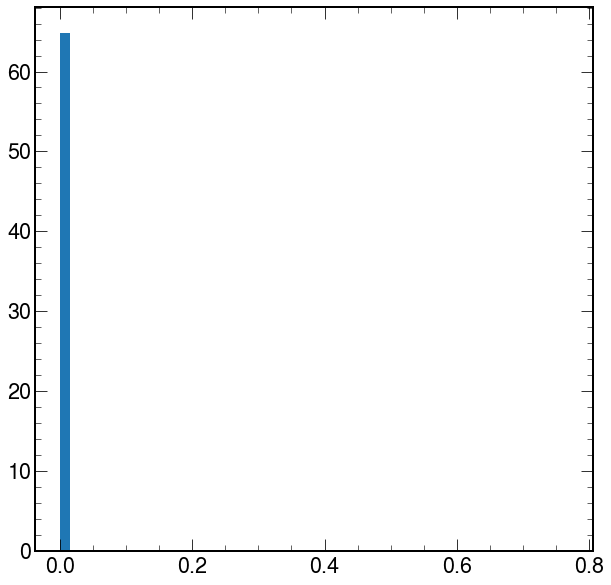

In [250]:
_ = plt.hist(omegai,bins =50, label="$\omega_s$",density=True)

### calculate the obs, such as energy density $\epsilon$, pressure $P$, entropy density $s$ and trace anomaly $\Delta=\frac{\epsilon - 3 P}{T}$ using the following equation:

$$
<O> = \sum_{n=1}^{1000} (\omega_{s,n}  O_n + \omega_{\Delta,n}  O_n)\\
\sigma_O = \sqrt{<O^2> - <O>^2}
$$

In [251]:
s_tot = []
d_tot = []
p_tot = []
e_tot = []

for j in range(2):
    for i in range(500):
        NN = np.load("./QCD_ex%s/run%s/data/EoS_data.npz"%(j+1, 500 * j + i))
        s_pred = NN["s_pred"].reshape(1,50) 
        D_pred = NN["Delta"].reshape(1,50) 
        E_pred = NN["ed"].reshape(1,50) 
        P_pred = NN["pr"].reshape(1,50) 
        s_tot.append(s_pred)        
        d_tot.append(D_pred)
        p_tot.append(P_pred)        
        e_tot.append(E_pred)        

In [252]:
def eva(x, omega):
#     omega = omega1 + omega2
    x_mean = (x * omega).sum(0)
    x_std = ((x**2 * omega).sum(0) - x_mean**2)
    return x_mean, x_std

In [253]:
s_array = np.concatenate(s_tot, axis=0)
d_array = np.concatenate(d_tot, axis=0)
p_array = np.concatenate(p_tot, axis=0)
e_array = np.concatenate(e_tot, axis=0)

In [254]:
s_mean, s_std  = eva(s_array,  omegai)
d_mean, d_std  = eva(d_array,  omegai)
p_mean, p_std  = eva(p_array,  omegai)
e_mean, e_std  = eva(e_array,  omegai)

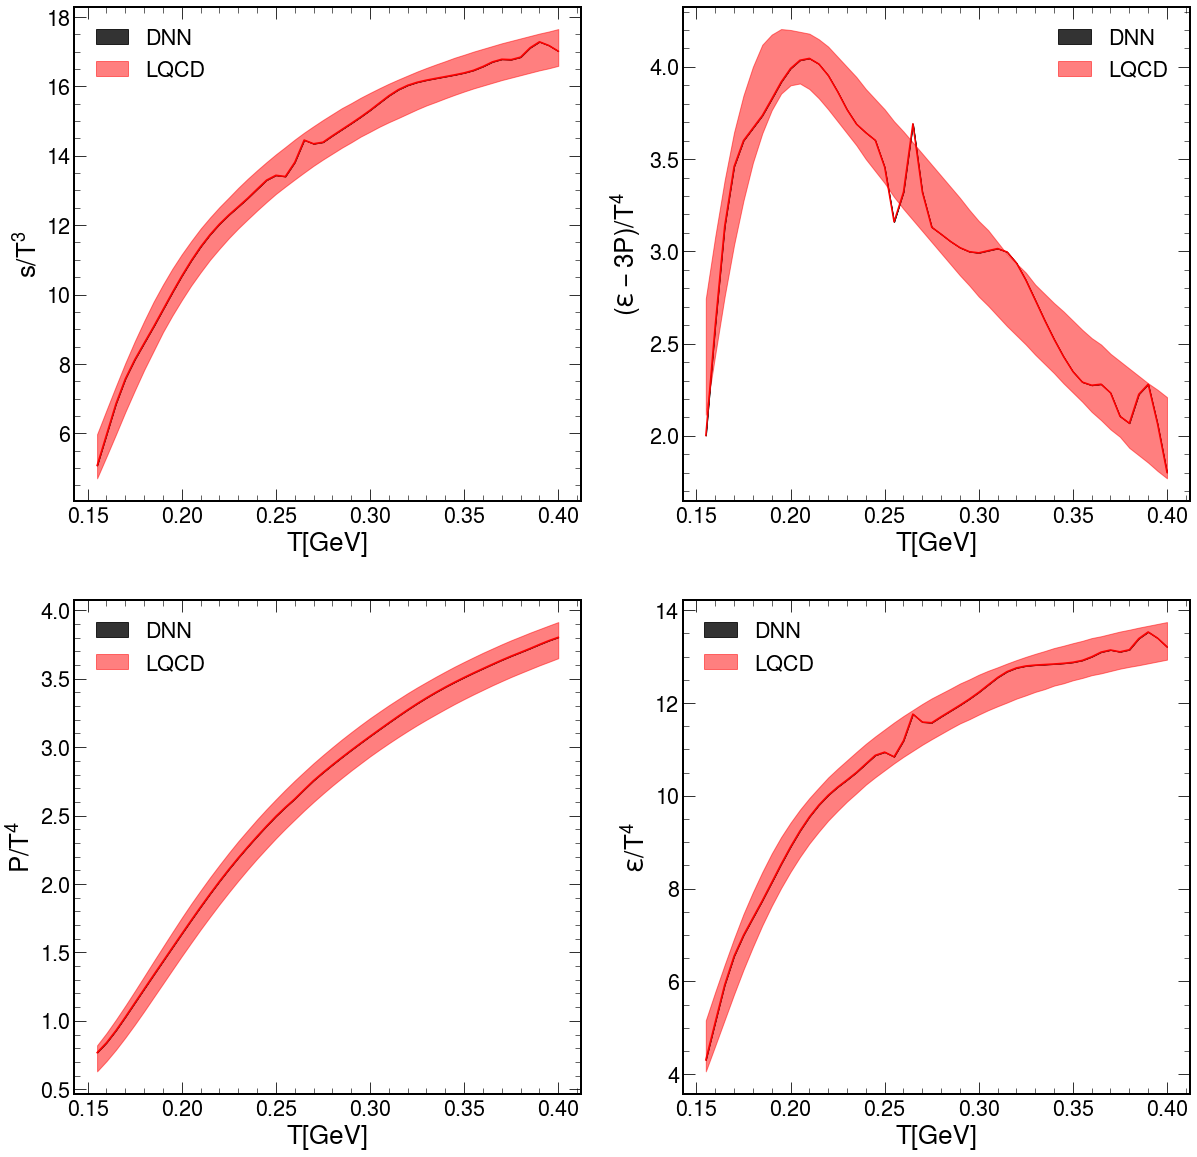

In [255]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.plot(LQCD["T"],s_mean / LQCD["T"] ** 3,"r")
plt.fill_between(LQCD["T"], s_mean / LQCD["T"] ** 3 -  s_std / LQCD["T"] ** 3, s_mean / LQCD["T"] ** 3 +  s_std / LQCD["T"] ** 3, color="black", alpha=0.8,label="DNN" )
plt.fill_between(LQCD["T"], LQCD["s/T^3"] - LQCD["ds"] , LQCD["s/T^3"] + LQCD["ds"] , alpha=0.5, color="red",label="LQCD")
plt.xlabel("T[GeV]",loc="center")
plt.ylabel("$s/T^3$",loc="center")
plt.legend()


plt.subplot(222)
plt.plot(LQCD["T"],d_mean / LQCD["T"] ** 4,"r")
plt.fill_between(LQCD["T"], d_mean / LQCD["T"] ** 4 -  d_std / LQCD["T"] ** 4, d_mean / LQCD["T"] ** 4+  d_std / LQCD["T"] ** 4, color="black", alpha=0.8,label="DNN" )
plt.fill_between(LQCD["T"], LQCD["TraceA"] - LQCD["dTraceA"], LQCD["TraceA"] + LQCD["dTraceA"], alpha=0.5, color="red",label="LQCD")
plt.xlabel("T[GeV]",loc="center")
plt.ylabel("$(\epsilon - 3P)/T^4$",loc="center")
plt.legend()

plt.subplot(223)
plt.plot(LQCD["T"],p_mean / LQCD["T"] ** 4,"r")
plt.fill_between(LQCD["T"], p_mean / LQCD["T"] ** 4 -  p_std / LQCD["T"] ** 4, p_mean / LQCD["T"] ** 4+  p_std / LQCD["T"] ** 4, color="black", alpha=0.8,label="DNN" )
plt.fill_between(LQCD["T"], LQCD["P/T^4"]- LQCD["dP"],LQCD["P/T^4"]+ LQCD["dP"], alpha=0.5, color="red",label="LQCD")
plt.xlabel("T[GeV]",loc="center")
plt.ylabel("$P/T^4$",loc="center")
plt.legend()


plt.subplot(224)
plt.plot(LQCD["T"],e_mean / LQCD["T"] ** 4,"r")
plt.fill_between(LQCD["T"], e_mean / LQCD["T"] ** 4 -  e_std / LQCD["T"] ** 4, e_mean / LQCD["T"] ** 4+  e_std / LQCD["T"] ** 4, color="black", alpha=0.8,label="DNN" )
plt.fill_between(LQCD["T"], LQCD["E/T^4"]- LQCD["dE"],LQCD["E/T^4"]+ LQCD["dE"], alpha=0.5, color="red",label="LQCD")
plt.xlabel("T[GeV]",loc="center")
plt.ylabel("$\epsilon/T^4$",loc="center")
plt.legend()

### plot the machine-learning quasi-particle masses

In [256]:
Mud_tot = []
Ms_tot = []
Mgluon_tot = []


for j in range(2):
    for i in range(500):
        NN = np.load("../withMC/QCD_ex%s/run%s/data/EoS_data_with_mass.npz"%(j+1, 500 * j + i))
        Mud = NN["Mud"].reshape(1,50) 
        Ms = NN["Ms"].reshape(1,50) 
        Mgluon = NN["Mgluon"].reshape(1,50) 

        Mud_tot.append(Mud)        
        Ms_tot.append(Ms)
        Mgluon_tot.append(Mgluon)        
   

In [257]:
Mud_array = np.concatenate(Mud_tot, axis=0)
Ms_array = np.concatenate(Ms_tot, axis=0)
Mgluon_array = np.concatenate(Mgluon_tot, axis=0)

In [258]:
Mud_mean, Mud_std  = eva(Mud_array,  omegai)
Ms_mean, Ms_std  = eva(Ms_array,  omegai)
Mgluon_mean,Mgluon_std  = eva(Mgluon_array,  omegai)

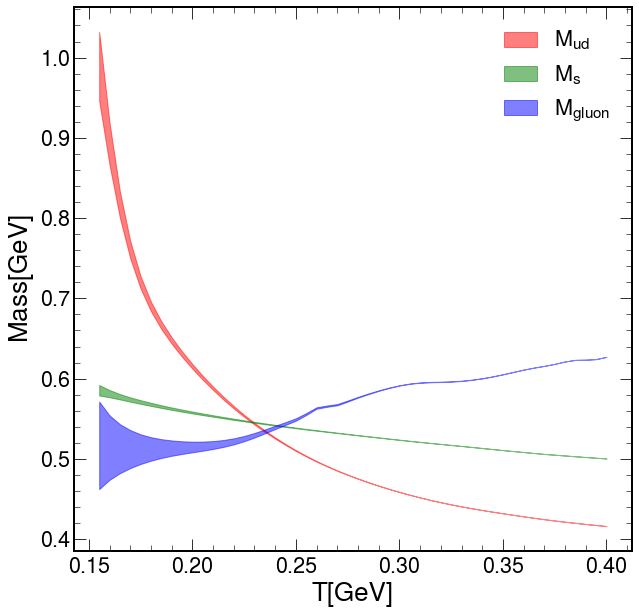

In [259]:
plt.fill_between(LQCD["T"], Mud_mean -  Mud_std , Mud_mean +  Mud_std , color="red", alpha=0.5,label="$M_{ud}$" )
plt.fill_between(LQCD["T"], Ms_mean -  Ms_std , Ms_mean +  Ms_std , color="green", alpha=0.5,label="$M_{s}$" )
plt.fill_between(LQCD["T"], Mgluon_mean -  Mgluon_std , Mgluon_mean +  Mgluon_std , color="b", alpha=0.5,label="$M_{gluon}$" )

plt.xlabel("T[GeV]",loc="center")
plt.ylabel("$Mass [GeV]$",loc="center")
plt.legend()